# Imports

# Neutron/Photon Separation
Can it be done???

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Append source directory to path
sys.path.append("../../src/")

# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_zip_train_test_data, load_unzip_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric, LpLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback, CustomModelCheckpoint
from helper_functions import create_output_directory, create_gif_from_pngs
from global_params import *
from model_functions import clip_out_beta
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load Data

In [16]:
batch_size = 128        # Batch size
project_directory = '../../projects/converge.10.14.2024.13.20/training/'
(train_X, train_y, train_misc), (test_X, test_y, test_misc) = load_zip_train_test_data(project_directory, batch_size=batch_size, max_files=5)
train_data = tf.data.Dataset.zip((train_X, train_y))
test_data = tf.data.Dataset.zip((test_X, test_y))
#h5file = "../../projects/converge.10.14.2024.13.20/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0010.h5"
# train_X,train_y,train_misc = load_unzip_data(h5file)

In [17]:
# Set training parameters
initial_lr = 1e-4       # Initial learning rate for CLR
max_lr = 1e-3           # Maximum learning rate for CLR
step_size = 20          # 20 batches for half cycle, so 40 batches for a full cycle
N_epochs = 100           # Number of epochs to train
q_min = 0.1             # q_min for the custom loss
tB = 0.5                # Minimum beta for clustering
tD = 0.28               # Minimum distance for clustering
ev_n = 3                # Event numbers to plot
alpha_p = 0.0             # Hyperparameter for weighing loss
# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the model
model = make_gravnet_model(
    K=150,
    N_feat=28,
    N_grav_layers=6,
    N_neighbors=[4,4,6,6,8,8],
    N_filters=64,
    use_sector=False
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Instantiate the custom loss function
custom_loss = CustomLoss(q_min=q_min, alpha_p=alpha_p)

# Compile the model with the new LpLossMetric
model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=[
        AttractiveLossMetric(q_min=q_min),
        RepulsiveLossMetric(q_min=q_min),
        CowardLossMetric(q_min=q_min),
        NoiseLossMetric(q_min=q_min),
        LpLossMetric(alpha_p=alpha_p) 
    ]
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

clr_callback = CyclicalLearningRate(
    initial_learning_rate=initial_lr, 
    max_learning_rate=max_lr, 
    step_size=step_size
)

# Extract train and test data for plotting
for x in train_X.take(1):
    ecal_x_train = x[0:0+ev_n]
    break
for y in train_y.take(1):
    ecal_y_train = y[0:0+ev_n]
    break
for misc in train_misc.take(1):
    ecal_misc_train= misc[0:0+ev_n]
    break

for x in test_X.take(1):
    ecal_x_test = x[0:0+ev_n]
    break
for y in test_y.take(1):
    ecal_y_test = y[0:0+ev_n]
    break
for misc in test_misc.take(1):
    ecal_misc_test = misc[0:0+ev_n]
    break

# Plot callbacks for training and testing data
ecal_train_plot_callback = PlotCallback(
    X=ecal_x_train,
    y=ecal_y_train,
    misc=ecal_misc_train,
    tB=tB,
    tD=tD,
    outdir=outdir,
    version="train",create_first_epoch_plots=True,batch_interval=1
)

ecal_test_plot_callback = PlotCallback(
    X=ecal_x_test,
    y=ecal_y_test,
    misc=ecal_misc_test,
    tB=tB,
    tD=tD,
    outdir=outdir,
    version="test"
)

# Callback to plot loss metrics during training
loss_plot_callback = LossPlotCallback(
    save_dir=outdir
)

# Create checkpoint directory if it doesn't exist
os.makedirs(f'{outdir}/checkpoints',exist_ok=True)

# Example usage:
checkpoint_filepath = f'{outdir}/checkpoints/'+'epoch_{epoch:04d}_batch_{batch:05d}.keras'

# Instantiate the custom callback
checkpoint_callback = CustomModelCheckpoint(filepath=checkpoint_filepath, save_freq_batches=1)


# Output the number of parameters in the model
print("Number of Parameters:", model.count_params())

Number of Parameters: 134494


In [18]:
# Train the model
history = model.fit(train_data,
                    batch_size=batch_size,
                    epochs=N_epochs,
                    shuffle=False,
                    #validation_data=test_data,
                    callbacks=[#early_stopping_callback,
                               #clr_callback,
                               #ecal_train_plot_callback,
                               #ecal_test_plot_callback,
                               #loss_plot_callback,
                               checkpoint_callback
                    ])

Epoch 1/100

Saved checkpoint at epoch 1, batch 1
      1/Unknown 12s 12s/step - attractive_loss: 0.1393 - coward_loss: 0.4072 - loss: 1.1528 - lp_loss: 0.0000e+00 - noise_loss: 0.5000 - repulsive_loss: 0.1063
Saved checkpoint at epoch 1, batch 2
      2/Unknown 13s 625ms/step - attractive_loss: 0.1220 - coward_loss: 0.4193 - loss: 1.1417 - lp_loss: 0.0000e+00 - noise_loss: 0.4982 - repulsive_loss: 0.1022
Saved checkpoint at epoch 1, batch 3
      3/Unknown 13s 618ms/step - attractive_loss: 0.1092 - coward_loss: 0.4280 - loss: 1.1334 - lp_loss: 0.0000e+00 - noise_loss: 0.4963 - repulsive_loss: 0.0998
Saved checkpoint at epoch 1, batch 4
      4/Unknown 14s 621ms/step - attractive_loss: 0.0997 - coward_loss: 0.4340 - loss: 1.1264 - lp_loss: 0.0000e+00 - noise_loss: 0.4945 - repulsive_loss: 0.0982
Saved checkpoint at epoch 1, batch 5
      5/Unknown 15s 622ms/step - attractive_loss: 0.0922 - coward_loss: 0.4382 - loss: 1.1201 - lp_loss: 0.0000e+00 - noise_loss: 0.4927 - repulsive_loss: 0

2024-10-29 13:23:50.042230: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - attractive_loss: 0.0422 - coward_loss: 0.1512 - loss: 0.2393 - lp_loss: 0.0000e+00 - noise_loss: 1.8961e-04 - repulsive_loss: 0.0456
Saved checkpoint at the end of epoch 22
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - attractive_loss: 0.0422 - coward_loss: 0.1511 - loss: 0.2393 - lp_loss: 0.0000e+00 - noise_loss: 1.8936e-04 - repulsive_loss: 0.0455
Epoch 23/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - attractive_loss: 0.0423 - coward_loss: 0.1506 - loss: 0.2384 - lp_loss: 0.0000e+00 - noise_loss: 1.7231e-04 - repulsive_loss: 0.0452
Saved checkpoint at the end of epoch 23
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - attractive_loss: 0.0423 - coward_loss: 0.1504 - loss: 0.2384 - lp_loss: 0.0000e+00 - noise_loss: 1.7209e-04 - repulsive_loss: 0.0452
Epoch 24/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - attractive_loss: 0.0425 - coward_loss: 0.1498 - loss: 0.2375 - lp_loss: 0.0000e+00 - noise_loss: 1.5867e-04 - repulsive_loss: 0.0450
Saved checkp

In [6]:
import os
from datetime import datetime
from PIL import Image
from collections import defaultdict
import tensorflow as tf

def create_gif_from_pngs_(outdir, gif_prefix="output", duration=500):
    """
    Create separate GIFs for each event from all .png files in the specified directory.
    Handles .png files ending in _train, _test, _batch, or neither, creating a GIF that includes all relevant files.

    Parameters:
    -----------
    outdir : str
        The directory containing .png files to be compiled into GIFs.
    gif_prefix : str
        The prefix for the output GIF files.
    duration : int
        Duration of each frame in the GIF in milliseconds.
    """
    # Find all .png files in the directory and group them by event number and batch number
    png_files = sorted([f for f in os.listdir(outdir) if f.endswith('.png')])

    # Dictionary to hold lists of files for each event, category, and batch
    event_files = defaultdict(lambda: {'train': [], 'test': [], 'none': [], 'batch': defaultdict(list)})

    # Group files by event number, category, and batch number
    for png_file in png_files:
        event_number = None
        batch_number = None
        category = None
        # Extract event number from the filename (assuming "ev#" is in the filename)
        for part in png_file.split('_'):
            if part.startswith("ev"):
                event_number = part
            if "train" in part:
                category = 'train'
            if "test" in part:
                category = 'test'

        # Append files to the correct category or batch group
        if event_number:
            if category == 'batch' and batch_number:
                event_files[event_number][category][batch_number].append(png_file)
            else:
                event_files[event_number][category].append(png_file)
    
    # Create a GIF for each event, category, and batch
    for event, file_dict in event_files.items():
        # Handle train, test, and none categories
        for category in ['none', 'train', 'test']:
            all_files = file_dict[category]
            if len(all_files) == 0:
                continue
            images = [Image.open(os.path.join(outdir, f)) for f in sorted(all_files)]
            gif_path = os.path.join(outdir, f"{gif_prefix}_{event}_{category}.gif")
            images[0].save(gif_path, save_all=True, append_images=images[1:], duration=duration, loop=0)
            print(f"GIF saved at: {gif_path}")
        

In [7]:
#create_gif_from_pngs("../../projects/converge.10.14.2024.13.20/tensorflow/episode_0002/config_0001/10_15_2024_0000/", "training.fast", duration=60, savedir = "../../projects/converge.10.14.2024.13.20/tensorflow/episode_0002/config_0001/")
create_gif_from_pngs(outdir, "training.slow", duration=500)
create_gif_from_pngs(outdir, "training.fast", duration=500)

# Understanding why the Attractive Loss Fails after More Iterations

In [3]:
working_epoch = "10"

# 09_26_2024 Model 13 was run for a while originally
# 09_26_2024 Model 19 was run with the SUM OVER BATCH SIZE flag in the loss (bad-->100, good-->98ish)
def accumulate_batches(dataset, Nevents, batch_size=128):
    accumulated_data = []
    num_samples = 0
    # Iterate through the dataset to accumulate batches
    for batch in dataset:
        # If adding this batch would exceed Nevents, trim the batch
        if num_samples + len(batch) > Nevents:
            remaining_events = Nevents - num_samples
            accumulated_data.append(batch[:remaining_events])  # Take only the needed part of the batch
            num_samples += remaining_events
            break
        else:
            accumulated_data.append(batch)
            num_samples += len(batch)
        
        if num_samples >= Nevents:
            break
    
    # Concatenate all batches into a single array
    return np.concatenate(accumulated_data, axis=0)

def get_eval(epoch, tB=0.7, tD=0.3, Nevents=128, batch_size=128, version="train"):
    #model_load_path = "./out/10_09_2024_0045/checkpoints/epoch_499.keras"

    #model_load_path = f"{outdir}/checkpoints/epoch_{epoch}.keras"
    model_load_path = f"../../projects/supercell.10.08.2024.18.28/tensorflow/episode_0008/config_0000/10_10_2024_0000/trained_model.keras"
    # Load the model
    model = tf.keras.models.load_model(model_load_path, custom_objects={
        'CustomLoss': CustomLoss, 
        'AttractiveLossMetric': AttractiveLossMetric,
        'RepulsiveLossMetric': RepulsiveLossMetric,
        'CowardLossMetric': CowardLossMetric,
        'NoiseLossMetric': NoiseLossMetric,
        'LpLossMetric': LpLossMetric,
        'clip_out_beta': clip_out_beta
    })

    # Choose between training and testing datasets
    if version == "train":
        ecal_x = accumulate_batches(train_X, Nevents, batch_size)
        ecal_y = accumulate_batches(train_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(train_misc, Nevents, batch_size)
    else:
        ecal_x = accumulate_batches(test_X, Nevents, batch_size)
        ecal_y = accumulate_batches(test_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(test_misc, Nevents, batch_size)
    try:
    #evaluator = Evaluator('../../projects/flightb741.09.24.2024.20.53/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.h5', Nevents=10)
        evaluator = Evaluator(X=ecal_x,y=ecal_y,misc=ecal_misc)
        evaluator.load_model(model)
        evaluator.predict()
        evaluator.cluster(0.5,0.3)
    except:
        evaluator = Evaluator(h5file,Nevents=batch_size)
        evaluator.load_model(model)
        evaluator.predict()
        evaluator.cluster(0.5,0.3)
    return evaluator


working_eval = get_eval(working_epoch, Nevents=200, batch_size=200)

I0000 00:00:1728917704.999903  852313 service.cc:146] XLA service 0x7fb3c001bac0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728917704.999963  852313 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-10-14 10:55:05.081617: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728917706.304258  852313 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1728917706.346116  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.425003  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.473227  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.516470  852478 on

1/7 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step

W0000 00:00:1728917706.731947  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.781620  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.840655  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.888903  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.935737  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917706.981438  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.025901  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.070020  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.111767  852478 onednn_matmul.cc:322] [Perf]: MatMul refer

2/7 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step

W0000 00:00:1728917707.156079  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.201134  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.241824  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.297749  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.346216  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.392702  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.439473  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.483726  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.524920  852478 onednn_matmul.cc:322] [Perf]: MatMul refer

3/7 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step

W0000 00:00:1728917707.606135  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.647482  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.692112  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.747691  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.798458  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.857575  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.907094  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.951501  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917707.992047  852478 onednn_matmul.cc:322] [Perf]: MatMul refer

4/7 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step

W0000 00:00:1728917708.077244  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.121397  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.162550  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.211335  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.255153  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.298251  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.342779  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.387204  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.429159  852478 onednn_matmul.cc:322] [Perf]: MatMul refer

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step

W0000 00:00:1728917708.518240  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.560914  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.603700  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.658860  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.704699  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.750063  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.797221  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.841684  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917708.888822  852478 onednn_matmul.cc:322] [Perf]: MatMul refer

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step

W0000 00:00:1728917708.984134  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917709.028168  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed
W0000 00:00:1728917709.071595  852478 onednn_matmul.cc:322] [Perf]: MatMul reference implementation being executed


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step


100%|███████████████████████████████████████| 198/198 [00:01<00:00, 192.24it/s]


In [107]:
# def plot(evaluator, ev):
#     df = evaluator.get_event_dataframe(ev)
#     plotter = ModelEcalPlotter(df,use_clas_calo_scale=True)
#     plotter.plot_all(tD=evaluator.tD)


# print("Working Loss Dictionary\n", "*" * 100)
# working_loss_df = working_eval.get_loss_df(q_min=q_min,alpha_p=alpha_p)
# display(working_loss_df.mean(), working_loss_df)
# plot(working_eval, 0)


In [4]:
from ECALDataReader import ECALDataReader
import matplotlib.pyplot as plt
def propagate_photons_to_z(mc_parts, z_desired, z_initial=0):
    """
    Propagates the photons (px, py, pz) to the desired z distance.
    """
    pid = mc_parts.pid
    px = mc_parts.px
    py = mc_parts.py
    pz = mc_parts.pz
    
    # Select photons with pid == 22
    photon_mask = (pid == 22)
    px = px[photon_mask]
    py = py[photon_mask]
    pz = pz[photon_mask]
    
    # Speed of light in cm/s
    speed_of_light = 2.998e10  # cm/s

    # Calculate momentum magnitude
    p = np.sqrt(px**2 + py**2 + pz**2)
    
    # Direction cosines (unit direction of momentum)
    p_hat_x = px / p
    p_hat_y = py / p
    p_hat_z = pz / p
    
    # Propagation step
    dz = z_desired - z_initial
    
    # Final x and y positions using dz and the direction cosines
    dx = (dz / p_hat_z) * p_hat_x
    dy = (dz / p_hat_z) * p_hat_y

    # Final x, y, and z coordinates
    x_final = dx
    y_final = dy
    z_final = z_desired
    return x_final, y_final, z_final

def propagate_neutrons_to_z(mc_parts, z_desired, z_initial=0):
    """
    Propagates the photons (px, py, pz) to the desired z distance.
    """
    pid = mc_parts.pid
    px = mc_parts.px
    py = mc_parts.py
    pz = mc_parts.pz
    
    # Select neutrons with pid == 2112
    neutron_mask = (pid == 2112)
    px = px[neutron_mask]
    py = py[neutron_mask]
    pz = pz[neutron_mask]
    
    # Speed of light in cm/s
    speed_of_light = 2.998e10  # cm/s

    # Calculate momentum magnitude
    p = np.sqrt(px**2 + py**2 + pz**2)
    
    # Direction cosines (unit direction of momentum)
    p_hat_x = px / p
    p_hat_y = py / p
    p_hat_z = pz / p
    
    # Propagation step
    dz = z_desired - z_initial
    
    # Final x and y positions using dz and the direction cosines
    dx = (dz / p_hat_z) * p_hat_x
    dy = (dz / p_hat_z) * p_hat_y

    # Final x, y, and z coordinates
    x_final = dx
    y_final = dy
    z_final = z_desired
    return x_final, y_final, z_final

def plot_photons(mc_parts, z_desired, axs):
    x,y,z = propagate_photons_to_z(mc_parts,z_desired)
    axs.scatter(x,y,marker="o",s=50)

def plot_neutrons(mc_parts, z_desired, axs):
    x,y,z = propagate_neutrons_to_z(mc_parts,z_desired)
    print(f"{x},{y}")
    axs.scatter(x,y,marker="^",s=50)

2   -98.542534
dtype: float64,2    4.703752
dtype: float64


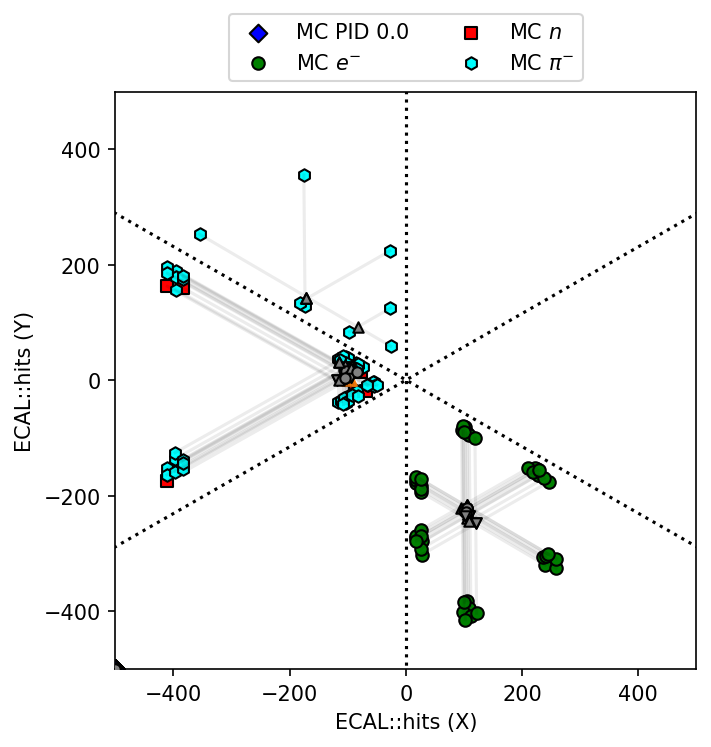

In [5]:
hipofile = h5file.replace("training","predict").replace(".h5","_ML.hipo")
reader = ECALDataReader(hipofile)
evnum = 73
offset = 72
for i,event in enumerate(reader.file):
    if i!=evnum:
        continue
    mc_parts = reader.get_dict("MC::Particle")
    break

mep = ModelEcalPlotter(working_eval.get_event_dataframe(offset),use_clas_calo_scale=True)

fig,axs=plt.subplots(1,1,figsize=(5,5),dpi=150)
mep.plot_mc_peaks(axs)
plot_photons(mc_parts, 700, axs)
plot_neutrons(mc_parts, 700, axs)
plt.show()

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
df = working_eval.clusters_df
df.event = df.event-df.event.values[0]
df = df[df.event==evnum]
df = df.sort_values(by=["sector","layer"])
# Calculate centroid_theta and centroid_phi
df['theta'] = np.arctan2(np.sqrt(df['x']**2 + df['y']**2), df['z']) * (180 / np.pi)
df['phi'] = np.arctan2(df['y'], df['x']) * (180 / np.pi)

# Reorder columns to place centroid_theta and centroid_phi after centroid_z
cols = df.columns.tolist()  # Get a list of all columns
# Find the index of 'centroid_z' to insert the new columns after it
idx = cols.index('z') + 1

# Insert the new columns in the desired position
new_cols = cols[:idx] + ['theta', 'phi'] + cols[idx:]
df = df[new_cols]
df

,event,status,sector,layer,energy,time,x,y,z,theta,phi,widthU,widthV,widthW,idU,idV,idW,coordU,coordV,coordW,uid,theta,phi
398,73.0,2,3,4,0.013170,169.321567,-171.659241,142.973694,727.829773,17.063470,140.209338,0,0,0,0,0,0,0,0,0,2.0,17.063470,140.209338
395,73.0,1,4,1,0.091112,149.317387,-103.345024,15.737941,741.503845,8.024618,171.341214,0,0,0,0,0,0,0,0,0,1.0,8.024618,171.341214
396,73.0,1,4,4,0.267270,151.220659,-101.809074,17.745243,778.600098,7.560705,170.112717,0,0,0,0,0,0,0,0,0,1.0,7.560705,170.112717
397,73.0,1,4,7,0.185921,152.662848,-96.918617,9.980756,801.010620,6.935122,174.120361,0,0,0,0,0,0,0,0,0,1.0,6.935122,174.120361
392,73.0,0,6,1,0.521810,147.823295,104.564941,-224.723953,675.237854,20.156720,-65.047255,0,0,0,0,0,0,0,0,0,0.0,20.156720,-65.047255
393,73.0,0,6,4,0.280713,149.444354,105.845604,-227.981049,709.929688,19.496726,-65.095798,0,0,0,0,0,0,0,0,0,0.0,19.496726,-65.095798
394,73.0,0,6,7,0.041975,149.272320,108.428467,-234.650055,726.036621,19.597238,-65.199010,0,0,0,0,0,0,0,0,0,0.0,19.597238,-65.199010


In [9]:
df = working_eval.dataframe
df.event = df.event-df.event.values[0]
df = df[df.event==evnum]
df = df[df.energy!=0]
df = df.sort_values(by=["sector","layer"])
# Calculate centroid_theta and centroid_phi
df['centroid_theta'] = np.arctan2(np.sqrt(df['centroid_x']**2 + df['centroid_y']**2), df['centroid_z']) * (180 / np.pi)
df['centroid_phi'] = np.arctan2(df['centroid_y'], df['centroid_x']) * (180 / np.pi)

# Reorder columns to place centroid_theta and centroid_phi after centroid_z
cols = df.columns.tolist()  # Get a list of all columns
# Find the index of 'centroid_z' to insert the new columns after it
idx = cols.index('centroid_z') + 1

# Insert the new columns in the desired position
new_cols = cols[:idx] + ['centroid_theta', 'centroid_phi'] + cols[idx:]
df = df[new_cols]
df

,event,energy,time,xo,yo,zo,xe,ye,ze,sector,layer,centroid_x,centroid_y,centroid_z,centroid_theta,centroid_phi,is_3way_same_group,is_2way_same_group,rec_pid,pindex,mc_pid,unique_otid,beta,xc,yc,cluster_id,is_cluster_leader,pred_pid,pred_photon,pred_neutron,pred_other,id,cluster_x,cluster_y,cluster_z,centroid_theta,centroid_phi
7230,73.0,0.005300,170.172226,-27.447449,224.163513,727.291077,-182.437515,134.679993,727.291077,3,4,-171.659241,142.973694,727.291077,17.075375,140.209351,1.0,0.0,-1.0,-1.0,-211.0,656.0,0.049709,0.743173,0.269874,2,0,1,0.354356,0.381117,0.264527,0,-171.659241,142.973694,727.829773,17.075375,140.209351
7255,73.0,0.000940,177.042450,-26.532104,124.959656,767.566406,-96.982162,84.285339,767.566406,3,4,-82.673950,92.546143,767.566406,9.183792,131.775284,0.0,1.0,-1.0,-1.0,-211.0,656.0,0.159177,0.347684,0.263907,1,0,0,0.403623,0.316613,0.279764,0,-101.809074,17.745243,778.600098,9.183792,131.775284
7249,73.0,0.001570,185.239090,-173.298447,129.363037,732.935181,-175.386337,355.648499,641.066528,3,5,-171.659241,142.973694,727.416016,17.072611,140.209351,1.0,0.0,-1.0,-1.0,-211.0,656.0,0.762952,0.649280,0.475140,2,1,1,0.341285,0.470349,0.188366,0,-171.659241,142.973694,727.829773,17.072611,140.209351
7238,73.0,0.002950,155.635406,-354.902466,253.084351,641.996643,-26.050034,59.153992,796.985596,3,6,-171.659241,142.973694,728.782104,17.042465,140.209351,1.0,1.0,-1.0,-1.0,-211.0,656.0,0.071444,0.668433,0.234161,2,0,1,0.356634,0.375553,0.267813,0,-171.659241,142.973694,727.829773,17.042465,140.209351
7217,73.0,0.012980,152.709549,-103.467041,40.210510,739.823669,-103.467041,-38.510498,739.823669,4,1,-104.339966,3.522278,739.823669,8.032196,178.066574,1.0,0.0,-211.0,1.0,-211.0,656.0,0.101788,0.228062,0.013115,1,0,1,0.254902,0.417533,0.327565,0,-103.345024,15.737941,741.503845,8.032196,178.066574
7233,73.0,0.004647,153.766495,-99.388672,37.907715,741.725464,-99.388672,-36.207748,741.725464,4,1,-97.143906,11.104401,741.725464,7.509605,173.478897,1.0,0.0,-211.0,1.0,-211.0,656.0,0.120113,0.209757,0.053518,1,0,1,0.259161,0.419700,0.321139,0,-103.345024,15.737941,741.503845,7.509605,173.478897
7234,73.0,0.004493,152.710098,-107.545425,42.513245,737.921875,-107.545425,-40.813248,737.921875,4,1,-107.058853,18.686523,737.921875,8.378009,170.099091,1.0,0.0,-211.0,1.0,-211.0,656.0,0.096930,0.219877,0.027683,1,0,1,0.263739,0.410495,0.325766,0,-103.345024,15.737941,741.503845,8.378009,170.099091
7252,73.0,0.001207,161.830475,-83.075089,28.696655,749.332581,-83.075089,-26.996689,749.332581,4,1,-84.775864,13.631836,749.332581,6.536923,170.865128,1.0,0.0,-1.0,-1.0,-211.0,656.0,0.179464,0.204134,0.057603,1,0,1,0.256137,0.425861,0.318003,0,-103.345024,15.737941,741.503845,6.536923,170.865128
7226,73.0,0.006520,170.435257,-54.341919,-10.523163,764.071655,-383.317871,175.185547,610.667664,4,2,-102.847549,16.159180,741.592712,7.991302,171.070816,1.0,0.0,-211.0,1.0,-211.0,656.0,0.009014,0.279786,0.105691,1,0,1,0.249812,0.405475,0.344713,0,-103.345024,15.737941,741.503845,7.991302,171.070816
7241,73.0,0.002460,172.369553,-49.864761,-7.995819,766.159424,-383.317383,180.240051,610.667908,4,2,-102.847549,21.213867,741.592712,8.059734,168.345322,1.0,0.0,-211.0,1.0,-211.0,656.0,0.009162,0.280913,0.112296,1,0,1,0.248555,0.407103,0.344342,0,-103.345024,15.737941,741.503845,8.059734,168.345322


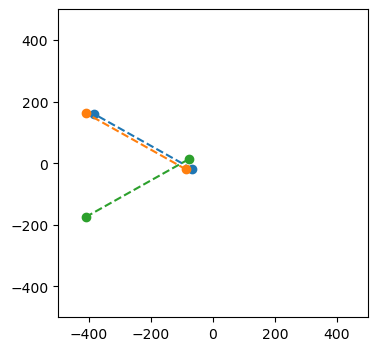

In [19]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
for _,row in df.iterrows():
    if row.unique_otid!=655:
        continue
    axs.plot([row.xo,row.xe],[row.yo,row.ye],marker="o",linestyle="--")
axs.set_xlim(-500,500)
axs.set_ylim(-500,500)
plt.show()